In [22]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
# import random
# import graphviz
# import scipy
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.utils import check_random_state
# from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.experimental import enable_halving_search_cv  # noqa
# from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
# from sympy import *
from IPython.display import display, Math
import os
# pd.set_option('display.max_columns', None)
# from datetime import datetime
import json
import time
import glob

def prep_labels(label_df):
    ### Prepare labels
    # Find unique labels and counts
    class_df = pd.DataFrame(label_df.value_counts()).reset_index()
    class_df = class_df.rename(columns={0:'population'})
    class_df['label'] = class_df.index
    # Convert to numerical labels
    proto2label = {proto:label for proto,label in class_df[['Prototype','label']].to_numpy()}
    label2proto = {label:proto for proto,label in class_df[['Prototype','label']].to_numpy()}
    label_df['label'] = [proto2label[proto] for proto in label_df.Prototype]
    return label_df, class_df, proto2label, label2proto


def reduce_feat_by_corr(feat_df, thresh=0.95):
    """
    Returns a copy of the input dataframe with correlated 
    features removed (defined as correlation > thresh)

    Parameters:
    feat_df (pandas.DataFrame): Dataframe containing the features
    thresh (float): Correlation threshold value

    Returns:
    pandas.DataFrame: A copy of the input dataframe with pruned features
    """
    feats_to_prune = set([])
    immune = set([])
    corr = feat_df.corr()
    for feat in feat_df.columns:
        # If we already pruned this feature, we're done here
        if feat in feats_to_prune: continue
        # If not, make it immune and discard things correlated with it
        immune.update({feat})
        correlated_features = set(corr[corr[feat] > thresh].index)
        feats_to_prune.update(correlated_features - immune)
    return feat_df.drop(columns=feats_to_prune).copy()


### Select proto
### Import data

# Import, Preprocess Data

In [27]:
### CONSTANTS ###########################################################
label_path = '../3_generate_features/final_label_array.csv'
feat_path = '../3_generate_features/dimensionless_cropped_final_feature_array.csv'
#########################################################################

label_df = pd.read_csv(label_path).drop(columns='Unnamed: 0',errors='ignore')
feat_df = pd.read_csv(feat_path).drop(columns='Unnamed: 0',errors='ignore')
rawf_df = pd.read_csv('../3_generate_features/cropped_final_feature_array.csv').drop(columns='Unnamed: 0',errors='ignore')

### Prep, find most populous prototypes
label_df, class_df, proto2label, label2_proto = prep_labels(label_df)
display(class_df.head(10))

,Prototype,population,label
0,Laves(cub)#MgCu2,1532,0
1,Fluorite#CaF2,507,1
2,Laves(2H)#MgZn2,475,2
3,Rutile#TiO2,467,3
4,AlB2,368,4
5,Pyrite#FeS2(cP12),250,5
6,CuAl2,237,6
7,CdI2(hP3),203,7
8,CaC2-I(I4/mmm),182,8
9,Marcasite#FeS2(oP6),169,9


In [30]:
label_df

,Prototype,label
0,Anatase#TiO2,31
1,Cristobalite#SiO2,26
2,Rutile#TiO2,3
3,Laves(2H)#MgZn2,2
4,Quartz(low)#SiO2,10
...,...,...
8743,Ag2F,93
8744,HgMoO4,159
8745,Laves(cub)#MgCu2,0
8746,Rutile#TiO2,3


### Select positive prototype, view the expression

In [35]:
### Select prototype to examine, load info
select_prototype = 'CaC2-I(I4/mmm)'
label_df['label_binary'] = (label_df.Prototype == select_prototype).astype(int)
seed = 0
fold = 0
save_prefix = f'models/c{proto2label[select_prototype]}vsall_{select_prototype.replace("/","slash")}_seed{seed}_fold{fold}'
with open(glob.glob(f'{save_prefix}*params*')[0]) as f:
    params = json.load(f)
with open(glob.glob(f'{save_prefix}*formula*')[0]) as f:
    formula = f.read()
print(formula)

add(e1_GSvolume_pa/e2_GSvolume_pa, -4.259)


### Plot learner boundary in feature space

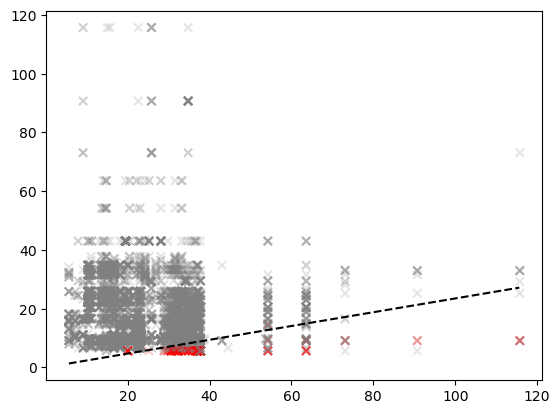

In [37]:
### Plot learner boundary
# Points
x = rawf_df.e1_GSvolume_pa
y = rawf_df.e2_GSvolume_pa
colors = ['red' if label == 1 else 'grey' for label in label_df.label_binary]
plt.scatter(x,y,c=colors, marker='x', alpha=0.2)
# Boundary
xb = np.arange(min(x),max(x))
yb = [x/4.259 for x in xb]
plt.plot(xb, yb, color='k', linestyle='--')
plt.show()

### Examine misclassified data

In [42]:
feat_df[feat_df['e1_GSvolume_pa/e2_GSvolume_pa'] > 4.259]

,e1_avg_oxi_pos/e1_avg_oxi_neg,(e1_avg_oxi_pos+e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos-e1_avg_oxi_neg)/e1_avg_oxi_pos,(e1_avg_oxi_pos+e1_avg_oxi_neg)/e1_avg_oxi_neg,(e1_avg_oxi_pos-e1_avg_oxi_neg)/e1_avg_oxi_neg,e1_avg_oxi_pos/e2_avg_oxi_pos,(e1_avg_oxi_pos+e2_avg_oxi_pos)/e1_avg_oxi_pos,(e1_avg_oxi_pos-e2_avg_oxi_pos)/e1_avg_oxi_pos,(e1_avg_oxi_pos+e2_avg_oxi_pos)/e2_avg_oxi_pos,(e1_avg_oxi_pos-e2_avg_oxi_pos)/e2_avg_oxi_pos,...,(e1_Electronegativity+e2_Electronegativity)/e2_Electronegativity,(e1_Electronegativity-e2_Electronegativity)/e2_Electronegativity,e1_GSvolume_pa/e2_GSvolume_pa,(e1_GSvolume_pa+e2_GSvolume_pa)/e1_GSvolume_pa,(e1_GSvolume_pa-e2_GSvolume_pa)/e1_GSvolume_pa,(e1_GSvolume_pa+e2_GSvolume_pa)/e2_GSvolume_pa,(e1_GSvolume_pa-e2_GSvolume_pa)/e2_GSvolume_pa,max_ionic_char,avg_ionic_char,chg_dispro
16,3.0,1.333333,0.666667,4.0,2.0,3.0,1.333333,0.666667,4.0,2.0,...,1.454545,-0.545455,5.709751,1.175139,0.824861,6.709751,4.709751,0.302324,0.067183,0
50,2.0,1.500000,0.500000,3.0,1.0,2.0,1.500000,0.500000,3.0,1.0,...,1.321569,-0.678431,12.962175,1.077148,0.922852,13.962175,11.962175,0.526794,0.058533,1
60,1.0,2.000000,0.000000,2.0,0.0,1.0,2.000000,0.000000,2.0,0.0,...,1.573529,-0.426471,4.632973,1.215844,0.784156,5.632973,3.632973,0.172400,0.038311,0
82,1.0,2.000000,0.000000,2.0,0.0,1.0,2.000000,0.000000,2.0,0.0,...,1.593137,-0.406863,4.424771,1.226000,0.774000,5.424771,3.424771,0.198203,0.044045,0
148,5.0,1.200000,0.800000,6.0,4.0,5.0,1.200000,0.800000,6.0,4.0,...,1.474510,-0.525490,5.627069,1.177712,0.822288,6.627069,4.627069,0.408814,0.090848,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,1.0,2.000000,0.000000,2.0,0.0,1.0,2.000000,0.000000,2.0,0.0,...,1.470588,-0.529412,5.682624,1.175975,0.824025,6.682624,4.682624,0.365948,0.081322,0
8699,1.0,2.000000,0.000000,2.0,0.0,1.0,2.000000,0.000000,2.0,0.0,...,1.588235,-0.411765,4.468456,1.223791,0.776209,5.468456,3.468456,0.161717,0.035937,0
8704,3.0,1.333333,0.666667,4.0,2.0,3.0,1.333333,0.666667,4.0,2.0,...,1.238693,-0.761307,5.586402,1.179006,0.820994,6.586402,4.586402,0.899261,0.199836,0
8718,1.0,2.000000,0.000000,2.0,0.0,1.0,2.000000,0.000000,2.0,0.0,...,1.486275,-0.513725,5.422872,1.184404,0.815596,6.422872,4.422872,0.348856,0.077524,0


In [54]:
### Gather false positives
pos_mask = feat_df['e1_GSvolume_pa/e2_GSvolume_pa'] > 4.259
fp_df = feat_df[pos_mask & (label_df.label_binary == 0)]
uniq, counts = np.unique(label_df[pos_mask & (label_df.label_binary == 0)].Prototype, return_counts=True)
# plt.hist(label_df[pos_mask & (label_df.label_binary == 0)].label)
print(sorted((zip(counts,uniq)),reverse=True))

[(60, 'Fluorite#CaF2'), (33, 'CaC2-II(C12/c1)#ThC2'), (24, 'CaC2-III(C12/m1)'), (23, 'AlB2'), (15, 'Cotunnite#PbCl2'), (10, 'Ba(OH)2'), (6, 'I2O4'), (6, 'CaC2-IV(Fm-3m)#KCN'), (5, 'Ni2In#Co1.75Ge'), (3, 'XeF2'), (3, 'ThH2'), (3, 'NaHC2'), (3, 'NaCl(defect)'), (3, 'Laves(cub)#MgCu2'), (3, 'KO2(mS12)'), (2, 'Sr(OH)2'), (2, 'Pyrite#FeS2(cP12)'), (2, 'Laves(2H)#MgZn2'), (2, 'KO2'), (2, 'CsOHH2O'), (2, 'CeCu2'), (1, 'ZrBeSi'), (1, 'K(H2O)(OH)'), (1, 'Ag2S(LT)')]


In [ ]:
CaC2-I(I4/mmm)